In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nfl_data_py as nfl

# Define the years to import
yrs = range(2019, 2021)
#yrs = 2022

# Play-by-Play Data
pbp_data = nfl.import_pbp_data(years=yrs)

# Player Stats
player_stats = nfl.import_seasonal_data(years=yrs, s_type='ALL')

# Weekly Rosters
weekly_rosters = nfl.import_weekly_rosters(years=yrs)

# Schedules
schedules = nfl.import_schedules(years=yrs)

# Injuries
injuries = nfl.import_injuries(years=yrs)

# Draft Data
draft_data = nfl.import_draft_picks(years=yrs)

# Combine Data
combine_data = nfl.import_combine_data(years=yrs)

# Weekly Fantasy Data
weekly_fantasy_data = nfl.import_weekly_data(years=yrs)

# Officiating Data
officiating_data = nfl.import_officials(years=yrs)

# Betting Lines
betting_lines = nfl.import_sc_lines(yrs)

# Depth Charts
depth_charts = nfl.import_depth_charts(years=yrs)

# Next Gen Stats
next_gen_stats = nfl.import_ngs_data(years=yrs, stat_type='passing')

2019 done.
2020 done.
Downcasting floats.
Downcasting floats.


Attempt to make a dvoa-type metric. Explore how downs impact expected points to make a better epa. 
- Points Above Replacement [PAR]
- First Down Above Replacement [FDAR] how likely are you to obtain another first down on this drive?

Use strength of schedule and matchups to weight player performance. Include situations like 4th quarter.

Can I predict snap count of players? If so, does that help predict points?

Make multiple functions that take in past data (play-by-play) 
- summarize the data by predicting the play outcome (yardage gained, score, 1st down)

Make a function that is able to summarize the effect of each variable on the outcome of the play

So, if each play occurs after the prior; I can make a cumulative sum that tracks the performance of teams
- New features like: Of last 100 plays how many have been touchdowns? How many have been sacks?
- total plays played

Can I feed all columns into a model to predict the future?
- Should I predict the next play? The game result? The next game result? Season win total?
- Can I find the most important features to then summarize for other problems? Can I then reduce the dimensions?
- Or should I just use averages and tendencies to summarize the current data in relation to future data?

Right now there is too much data for each player to put into one dataset to predict the next play
- Feature engineering to organize players based on three or four categories (athletisism, schemes, accolades...)
    - Production (reference for a category to qualify as being good)
        - explosive play rate
        - clutch rating
        - performance after explosive plays
        - consistency rating
        - teammate assistance
        - luck rating (drops, fumble recovery, missed field goals)
    - Tangibles (Athleticism)
        - age, age trends for position
        - height
        - weight
        - speed
        - strength
        - change in weight
        - injuries, return to injury effectiveness
        - total tackles endured
        - performance drop off on short rest times (thursday night games)
    - Schemes (Usage)
        - percent of snaps throwing, catching, running the ball (of specific player and of team)
        - 2-minute drill snap percentage
        - percent of snaps at each position
        - personnel frequencies
        - down/redzone usage
        - aggressiveness rating
        - contact rate (tackle rate)
    - Accolades (Intangibles)
        - salary
        - awards
        - draft stock
        - playoff wins
        - betting lines
        - how many teams have they been on?
- Reduce dimension through cluster analysis (referencing production differences)
- Combine all categories for each player on each play to predict the future

In [2]:
game_info = [
    'play_id', 'game_id', 'old_game_id_x', 'home_team', 'away_team', 'season_type', 'week', 
    'game_date', 'total_home_score', 'total_away_score', 'posteam', 'posteam_type', 'defteam', 
    'location', 'stadium', 'weather', 'temp', 'wind', 'roof', 'surface', 'home_coach', 'away_coach', 
    'stadium_id', 'game_stadium', 'away_score', 'home_score', 'result', 'total', 'spread_line', 
    'total_line', 'div_game', 'home_opening_kickoff', 'nflverse_game_id', 'old_game_id_y'
]

drive_info = [
    'drive', 'drive_real_start_time', 'drive_play_count', 'drive_time_of_possession', 
    'drive_first_downs', 'drive_inside20', 'drive_ended_with_score', 'drive_quarter_start', 
    'drive_quarter_end', 'drive_yards_penalized', 'drive_start_transition', 'drive_end_transition', 
    'drive_game_clock_start', 'drive_game_clock_end', 'drive_start_yard_line', 'drive_end_yard_line', 
    'drive_play_id_started', 'drive_play_id_ended', 'fixed_drive', 'fixed_drive_result'
]

play_info = [
    'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 
    'quarter_end', 'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 
    'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 
    'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 
    'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result', 
    'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout', 'timeout_team', 'td_team', 
    'td_player_name', 'td_player_id', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 
    'score_differential', 'posteam_score', 'defteam_score', 'posteam_score_post', 'defteam_score_post', 
    'score_differential_post', 'no_score_prob', 'opp_fg_prob', 'opp_safety_prob', 'opp_td_prob', 
    'fg_prob', 'safety_prob', 'td_prob', 'extra_point_prob', 'two_point_conversion_prob', 'ep', 'epa', 
    'total_home_epa', 'total_away_epa', 'total_home_rush_epa', 'total_away_rush_epa', 
    'total_home_pass_epa', 'total_away_pass_epa', 'air_epa', 'yac_epa', 'comp_air_epa', 'comp_yac_epa', 
    'total_home_comp_air_epa', 'total_away_comp_air_epa', 'total_home_comp_yac_epa', 
    'total_away_comp_yac_epa', 'total_home_raw_air_epa', 'total_away_raw_air_epa', 
    'total_home_raw_yac_epa', 'total_away_raw_yac_epa', 'wp', 'def_wp', 'home_wp', 'away_wp', 'wpa', 
    'vegas_wpa', 'vegas_home_wpa', 'home_wp_post', 'away_wp_post', 'vegas_wp', 'vegas_home_wp', 
    'total_home_rush_wpa', 'total_away_rush_wpa', 'total_home_pass_wpa', 'total_away_pass_wpa', 
    'air_wpa', 'yac_wpa', 'comp_air_wpa', 'comp_yac_wpa', 'total_home_comp_air_wpa', 
    'total_away_comp_air_wpa', 'total_home_comp_yac_wpa', 'total_away_comp_yac_wpa', 
    'total_home_raw_air_wpa', 'total_away_raw_air_wpa', 'total_home_raw_yac_wpa', 'total_away_raw_yac_wpa'
]

player_actions = [
    'rush_attempt', 'pass_attempt', 'sack', 'qb_hit', 'qb_hit_1_player_id', 'qb_hit_1_player_name', 
    'qb_hit_2_player_id', 'qb_hit_2_player_name', 'solo_tackle', 'assist_tackle', 'tackled_for_loss', 
    'tackle_for_loss_1_player_id', 'tackle_for_loss_1_player_name', 'tackle_for_loss_2_player_id', 
    'tackle_for_loss_2_player_name', 'forced_fumble_player_1_team', 'forced_fumble_player_1_player_id', 
    'forced_fumble_player_1_player_name', 'forced_fumble_player_2_team', 'forced_fumble_player_2_player_id', 
    'forced_fumble_player_2_player_name', 'fumble_forced', 'fumble_not_forced', 'fumble_out_of_bounds', 
    'fumble_lost', 'fumble_recovery_1_team', 'fumble_recovery_1_yards', 'fumble_recovery_1_player_id', 
    'fumble_recovery_1_player_name', 'fumble_recovery_2_team', 'fumble_recovery_2_yards', 
    'fumble_recovery_2_player_id', 'fumble_recovery_2_player_name', 'interception', 'interception_player_id', 
    'interception_player_name', 'lateral_interception_player_id', 'lateral_interception_player_name', 
    'pass_defense_1_player_id', 'pass_defense_1_player_name', 'pass_defense_2_player_id', 
    'pass_defense_2_player_name', 'punt_blocked', 'punt_inside_twenty', 'punt_in_endzone', 
    'punt_out_of_bounds', 'punt_downed', 'punt_fair_catch', 'kickoff_inside_twenty', 'kickoff_in_endzone', 
    'kickoff_out_of_bounds', 'kickoff_downed', 'kickoff_fair_catch', 'own_kickoff_recovery', 
    'own_kickoff_recovery_td', 'own_kickoff_recovery_player_id', 'own_kickoff_recovery_player_name', 
    'blocked_player_id', 'blocked_player_name', 'punt_returner_player_id', 'punt_returner_player_name', 
    'kickoff_returner_player_id', 'kickoff_returner_player_name', 'punter_player_id', 'punter_player_name', 
    'kicker_player_id', 'kicker_player_name', 'passer_player_id', 'passer_player_name', 'passing_yards', 
    'receiver_player_id', 'receiver_player_name', 'receiving_yards', 'rusher_player_id', 'rusher_player_name', 
    'rushing_yards', 'lateral_receiver_player_id', 'lateral_receiver_player_name', 'lateral_receiving_yards', 
    'lateral_rusher_player_id', 'lateral_rusher_player_name', 'lateral_rushing_yards', 'lateral_sack_player_id', 
    'lateral_sack_player_name', 'assist_tackle_1_player_id', 'assist_tackle_1_player_name', 
    'assist_tackle_1_team', 'assist_tackle_2_player_id', 'assist_tackle_2_player_name', 
    'assist_tackle_2_team', 'assist_tackle_3_player_id', 'assist_tackle_3_player_name', 
    'assist_tackle_3_team', 'assist_tackle_4_player_id', 'assist_tackle_4_player_name', 
    'assist_tackle_4_team', 'solo_tackle_1_team', 'solo_tackle_2_team', 'solo_tackle_1_player_id', 
    'solo_tackle_2_player_id', 'solo_tackle_1_player_name', 'solo_tackle_2_player_name', 'fumbled_1_team', 
    'fumbled_1_player_id', 'fumbled_1_player_name', 'fumbled_2_player_id', 'fumbled_2_player_name', 
    'fumbled_2_team', 'return_team', 'return_yards', 'penalty_team', 'penalty_player_id', 
    'penalty_player_name', 'penalty_yards', 'penalty', 'penalty_type', 'replay_or_challenge', 
    'replay_or_challenge_result', 'defensive_two_point_attempt', 'defensive_two_point_conv', 
    'defensive_extra_point_attempt', 'defensive_extra_point_conv', 'first_down_rush', 'first_down_pass', 
    'first_down_penalty', 'third_down_converted', 'third_down_failed', 'fourth_down_converted', 
    'fourth_down_failed', 'incomplete_pass', 'touchback', 'safety', 'tackled_for_loss', 'fumble', 
    'complete_pass', 'lateral_reception', 'lateral_rush', 'lateral_return', 'lateral_recovery', 
    'touchdown', 'pass_touchdown', 'rush_touchdown', 'return_touchdown', 'extra_point_attempt', 
    'two_point_attempt', 'field_goal_attempt', 'kickoff_attempt', 'punt_attempt'
]

special_teams = [
    'special_teams_play', 'st_play_type', 'punt_blocked', 'punt_inside_twenty', 'punt_in_endzone', 
    'punt_out_of_bounds', 'punt_downed', 'punt_fair_catch', 'kickoff_inside_twenty', 'kickoff_in_endzone', 
    'kickoff_out_of_bounds', 'kickoff_downed', 'kickoff_fair_catch', 'own_kickoff_recovery', 
    'own_kickoff_recovery_td', 'punt_returner_player_id', 'punt_returner_player_name', 
    'kickoff_returner_player_id', 'kickoff_returner_player_name', 'punter_player_id', 'punter_player_name', 
    'kicker_player_id', 'kicker_player_name', 'blocked_player_id', 'blocked_player_name'
]

clock_and_time = [
    'start_time', 'time_of_day', 'play_clock', 'end_clock_time', 'drive_game_clock_start', 
    'drive_game_clock_end'
]

advanced_metrics = [
    'cp', 'cpoe', 'series', 'series_success', 'series_result', 'order_sequence', 'nfl_api_id', 
    'play_deleted', 'play_type_nfl', 'aborted_play', 'success', 'passer', 'passer_jersey_number', 
    'rusher', 'rusher_jersey_number', 'receiver', 'receiver_jersey_number', 'pass', 'rush', 'first_down', 
    'special', 'play', 'passer_id', 'rusher_id', 'receiver_id', 'name', 'jersey_number', 'id', 
    'fantasy_player_name', 'fantasy_player_id', 'fantasy', 'fantasy_id', 'out_of_bounds', 'qb_epa', 
    'xyac_epa', 'xyac_mean_yardage', 'xyac_median_yardage', 'xyac_success', 'xyac_fd', 'xpass', 
    'pass_oe', 'possession_team', 'offense_formation', 'offense_personnel', 'defenders_in_box', 
    'defense_personnel', 'number_of_pass_rushers', 'players_on_play', 'offense_players', 'defense_players', 
    'n_offense', 'n_defense', 'ngs_air_yards', 'time_to_throw', 'was_pressure', 'route', 
    'defense_man_zone_type', 'defense_coverage_type'
]

In [3]:
# load depth chart data
depth_charts[['season', 'club_code', 'week', 'depth_team', 'gsis_id', 'position', 'full_name']].head(10)

,season,club_code,week,depth_team,gsis_id,position,full_name
0,2019,ATL,1.0,3,00-0035285,CB,Jordan Miller
1,2019,ATL,1.0,2,00-0032592,CB,Sharrod Neasman
2,2019,ATL,1.0,1,00-0028130,P,Matt Bosher
3,2019,ATL,1.0,1,00-0028130,P,Matt Bosher
4,2019,ATL,1.0,1,00-0028130,P,Matt Bosher
5,2019,ATL,1.0,1,00-0030465,RB,Kenjon Barner
6,2019,ATL,1.0,1,00-0030465,RB,Kenjon Barner
7,2019,ATL,1.0,2,00-0027958,DE,Adrian Clayborn
8,2019,ATL,1.0,1,00-0028024,DE,Allen Bailey
9,2019,ATL,1.0,1,00-0032240,OLB,Vic Beasley


In [4]:
# pbp data
pbp_data[['game_id', 'week', 'posteam', 'play_id', 'play_type', 'offense_players']].sort_values(['game_id', 'play_id']).head()

,game_id,week,posteam,play_id,play_type,offense_players
0,2019_01_ATL_MIN,1,None,1.0,None,
1,2019_01_ATL_MIN,1,ATL,36.0,kickoff,00-0035150;00-0033336;00-0032918;00-0032422;00...
2,2019_01_ATL_MIN,1,ATL,51.0,pass,00-0035235;00-0028042;00-0031279;00-0026997;00...
3,2019_01_ATL_MIN,1,ATL,79.0,run,00-0035235;00-0030968;00-0031279;00-0026997;00...
4,2019_01_ATL_MIN,1,ATL,100.0,run,00-0035235;00-0031279;00-0026997;00-0032392;00...


## Split offensive players into columns

In [5]:
# Split the offense_players column into multiple columns for each player
offensive_players = pbp_data['offense_players'].str.split(';', expand=True)

# Ensure there are always 11 columns by filling missing values with None
offensive_players = offensive_players.reindex(columns=range(11), fill_value=None)

# Rename the columns
offensive_players.columns = [
    'offensive_player_1', 'offensive_player_2', 'offensive_player_3', 'offensive_player_4', 
    'offensive_player_5', 'offensive_player_6', 'offensive_player_7', 'offensive_player_8', 
    'offensive_player_9', 'offensive_player_10', 'offensive_player_11'
]

# Concatenate the original pbp_data with the new offense_players columns
pbp_wide = pd.concat([pbp_data[['game_id', 'week', 'posteam', 'play_id', 'play_type']], offensive_players], axis=1)

# Filter rows where play_type is not 'None'
pbp_wide = pbp_wide[pbp_wide['play_type'].notna()]

pbp_wide.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92190 entries, 1 to 94961
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   game_id              92190 non-null  object 
 1   week                 92190 non-null  int32  
 2   posteam              88315 non-null  object 
 3   play_id              92190 non-null  float32
 4   play_type            92190 non-null  object 
 5   offensive_player_1   92181 non-null  object 
 6   offensive_player_2   88306 non-null  object 
 7   offensive_player_3   88306 non-null  object 
 8   offensive_player_4   88306 non-null  object 
 9   offensive_player_5   88306 non-null  object 
 10  offensive_player_6   88305 non-null  object 
 11  offensive_player_7   88305 non-null  object 
 12  offensive_player_8   88305 non-null  object 
 13  offensive_player_9   88305 non-null  object 
 14  offensive_player_10  88304 non-null  object 
 15  offensive_player_11  88286 non-null 

# Create Useful columns

In [6]:
# Change 'fixed_drive_result' from text to points
pbp_data['fixed_drive_result'] = pbp_data['fixed_drive_result'].replace({
    'Touchdown': 6,
    'Field Goal': 3,
    'Safety': -2,
    'End of Half': 0,
    'End of Game': 0,
    'Missed FG': 0,
    'No Play': 0,
    'Turnover on Downs': 0,
    'Fumble': 0,
    'Interception': 0,
    'Punt': 0,
    'Turnover': 0
})

## Transform to long format

In [7]:
# Transform pbp to long format with offense_player columns as rows
pbp_long = pd.melt(pbp_wide, id_vars=['game_id', 'week', 'posteam', 'play_id'], 
                   value_vars=offensive_players.columns, var_name='off_player_number', value_name='player_id')
pbp_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014090 entries, 0 to 1014089
Data columns (total 6 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   game_id            1014090 non-null  object 
 1   week               1014090 non-null  int32  
 2   posteam            971465 non-null   object 
 3   play_id            1014090 non-null  float32
 4   off_player_number  1014090 non-null  object 
 5   player_id          975215 non-null   object 
dtypes: float32(1), int32(1), object(4)
memory usage: 38.7+ MB


## Discover the best length of recency bias to predict the future (10, 100, 1000 snaps)

In [8]:
# Transform pbp to long format with offense_player columns as rows
pbp_long = pd.melt(pbp_wide, id_vars=['game_id', 'posteam', 'play_id'], 
                   value_vars=offensive_players.columns, var_name='off_player_number', value_name='player_id')

# Columns necessary for merge
merge_cols = ['game_id', 'posteam', 'play_id']

# Useful/important columns to merge from pbp_data
useful_cols = [
    'play_type', # type of play (pass, rush, etc.
    'ydstogo', # yards to go for the next first down
    #'ydsnet', # net yards gained on the play (yards gained - penalty yards) and includes kickoff
    'yards_gained', # yards gained on the play
    #'fixed_drive_result', # result of the drive (e.g., touchdown, field goal, etc.)
    'epa', # expected points added on the play
    'wpa', # win probability added on the play
]

# Merge 'ydstogo', 'ydsnet', 'yards_gained' from pbp_data to pbp_long
pbp_long = pbp_long.merge(pbp_data[merge_cols + useful_cols],
                            on=merge_cols, how='left')

pbp_long.head(10)

,game_id,posteam,play_id,off_player_number,player_id,play_type,ydstogo,yards_gained,epa,wpa
0,2019_01_ATL_MIN,ATL,36.0,offensive_player_1,00-0035150,kickoff,0.0,0.0,-0.000000,-0.000000
1,2019_01_ATL_MIN,ATL,51.0,offensive_player_1,00-0035235,pass,10.0,-8.0,-1.658763,-0.035015
2,2019_01_ATL_MIN,ATL,79.0,offensive_player_1,00-0035235,run,18.0,4.0,-0.538914,-0.018435
3,2019_01_ATL_MIN,ATL,100.0,offensive_player_1,00-0035235,run,14.0,12.0,0.142138,0.018007
4,2019_01_ATL_MIN,ATL,121.0,offensive_player_1,00-0034411,punt,2.0,0.0,-4.034299,-0.113866
5,2019_01_ATL_MIN,MIN,148.0,offensive_player_1,00-0033893,no_play,10.0,0.0,-1.125093,-0.018770
6,2019_01_ATL_MIN,MIN,185.0,offensive_player_1,00-0033893,pass,20.0,8.0,0.258130,0.006673
7,2019_01_ATL_MIN,MIN,214.0,offensive_player_1,00-0033893,pass,12.0,23.0,2.785377,0.050186
8,2019_01_ATL_MIN,MIN,239.0,offensive_player_1,00-0033909,extra_point,0.0,0.0,0.051172,0.001193
9,2019_01_ATL_MIN,ATL,255.0,offensive_player_1,00-0033969,kickoff,0.0,0.0,-0.612925,-0.011815


C:\Users\Jack\AppData\Local\Temp\ipykernel_23628\3686387692.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_long.loc[:, 'running_avg_player_epa'] = pbp_long.groupby('player_id', group_keys=False)['epa'].apply(lambda x: x.shift(1).rolling(a, min_periods=1).mean())
C:\Users\Jack\AppData\Local\Temp\ipykernel_23628\3686387692.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_long.loc[:, 'running_avg_player_wpa'] = pbp_long.groupby('player_id', group_keys=False)['wpa'].apply(lambda x: x.shift(1).

Initial rows: 966622
After dropna: 964480
After filtering by cumulative_player_snaps: 956429


C:\Users\Jack\AppData\Local\Temp\ipykernel_23628\3686387692.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_long.loc[:, 'running_avg_player_epa'] = pbp_long.groupby('player_id', group_keys=False)['epa'].apply(lambda x: x.shift(1).rolling(a, min_periods=1).mean())
C:\Users\Jack\AppData\Local\Temp\ipykernel_23628\3686387692.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_long.loc[:, 'running_avg_player_wpa'] = pbp_long.groupby('player_id', group_keys=False)['wpa'].apply(lambda x: x.shift(1).

Initial rows: 928016
After dropna: 926174
After filtering by cumulative_player_snaps: 884966


C:\Users\Jack\AppData\Local\Temp\ipykernel_23628\3686387692.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_long.loc[:, 'running_avg_player_epa'] = pbp_long.groupby('player_id', group_keys=False)['epa'].apply(lambda x: x.shift(1).rolling(a, min_periods=1).mean())
C:\Users\Jack\AppData\Local\Temp\ipykernel_23628\3686387692.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_long.loc[:, 'running_avg_player_wpa'] = pbp_long.groupby('player_id', group_keys=False)['wpa'].apply(lambda x: x.shift(1).

Initial rows: 884966
After dropna: 883303
After filtering by cumulative_player_snaps: 810055


C:\Users\Jack\AppData\Local\Temp\ipykernel_23628\3686387692.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_long.loc[:, 'running_avg_player_epa'] = pbp_long.groupby('player_id', group_keys=False)['epa'].apply(lambda x: x.shift(1).rolling(a, min_periods=1).mean())
C:\Users\Jack\AppData\Local\Temp\ipykernel_23628\3686387692.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_long.loc[:, 'running_avg_player_wpa'] = pbp_long.groupby('player_id', group_keys=False)['wpa'].apply(lambda x: x.shift(1).

Initial rows: 645311
After dropna: 644379
After filtering by cumulative_player_snaps: 465633


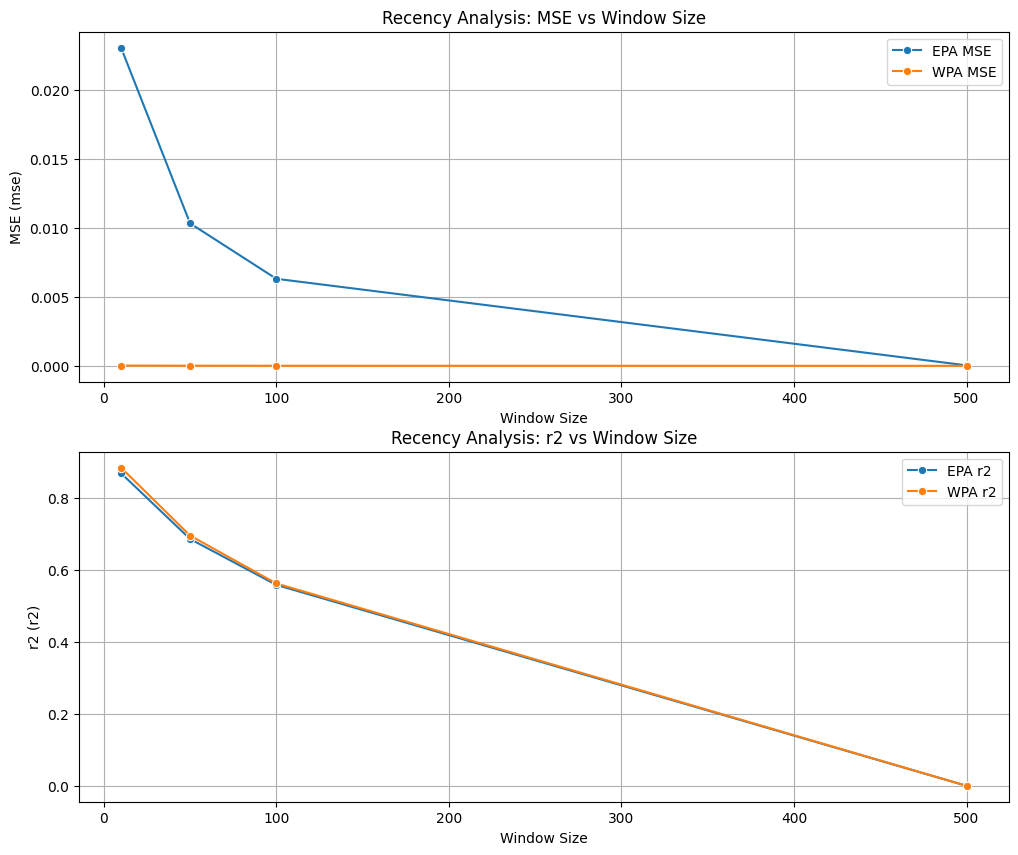

In [ ]:
import pandas as pd
import nfl_data_py as nfl
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Define the recency_analysis function
def recency_analysis(pbp_long, a=10):
    # Disable warnings
    import warnings
    warnings.filterwarnings("ignore")

    # Cumulative stats
    pbp_long['cumulative_player_snaps'] = pbp_long.groupby('player_id').cumcount() + 1
    pbp_long['cumulative_player_epa'] = pbp_long.groupby('player_id')['epa'].cumsum()
    pbp_long['cumulative_player_wpa'] = pbp_long.groupby('player_id')['wpa'].cumsum()
    pbp_long['cumulative_player_yards'] = pbp_long.groupby('player_id')['yards_gained'].cumsum()

    # Filter for snaps
    pbp_long = pbp_long[pbp_long['cumulative_player_snaps'] >= (a/2)]

    # Rolling averages without data leakage
    pbp_long.loc[:, 'running_avg_player_epa'] = pbp_long.groupby('player_id', group_keys=False)['epa'].apply(lambda x: x.shift(1).rolling(a, min_periods=1).mean())
    pbp_long.loc[:, 'running_avg_player_wpa'] = pbp_long.groupby('player_id', group_keys=False)['wpa'].apply(lambda x: x.shift(1).rolling(a, min_periods=1).mean())
    pbp_long.loc[:, 'running_avg_player_yards'] = pbp_long.groupby('player_id', group_keys=False)['yards_gained'].apply(lambda x: x.shift(1).rolling(a, min_periods=1).mean())

    # Future rolling averages
    pbp_long.loc[:, 'future_avg_player_epa'] = pbp_long.groupby('player_id', group_keys=False)['epa'].apply(lambda x: x.shift(-1).rolling(500, min_periods=1).mean())
    pbp_long.loc[:, 'future_avg_player_wpa'] = pbp_long.groupby('player_id', group_keys=False)['wpa'].apply(lambda x: x.shift(-1).rolling(500, min_periods=1).mean())

    # Delta features: difference between current and future rolling average
    pbp_long.loc[:, 'delta_avg_player_epa'] = pbp_long['future_avg_player_epa'] - pbp_long['running_avg_player_epa']
    pbp_long.loc[:, 'delta_avg_player_wpa'] = pbp_long['future_avg_player_wpa'] - pbp_long['running_avg_player_wpa']

    # Debug statement
    print(f"Initial rows: {len(pbp_long)}")
    pbp_long.dropna(subset=['delta_avg_player_epa', 'delta_avg_player_wpa'], inplace=True)
    print(f"After dropna: {len(pbp_long)}")
    pbp_long = pbp_long[pbp_long['cumulative_player_snaps'] >= a]
    print(f"After filtering by cumulative_player_snaps: {len(pbp_long)}")

    # Initialize the model
    model = Ridge(alpha=1.0)
    scaler = StandardScaler()
    kf = KFold(n_splits=2, shuffle=True, random_state=42)
    results = []

    dependent_vars = ['delta_avg_player_epa', 'delta_avg_player_wpa']
    independent_vars = ['running_avg_player_epa', 'running_avg_player_wpa', 'cumulative_player_snaps']

    for dep_var in dependent_vars:
        for train_index, test_index in kf.split(pbp_long):
            # Split the data into training and testing sets
            X_train, X_test = pbp_long[independent_vars].iloc[train_index], pbp_long[independent_vars].iloc[test_index]
            y_train, y_test = pbp_long[dep_var].iloc[train_index], pbp_long[dep_var].iloc[test_index]

            # Scale the features
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # Fit the model
            model.fit(X_train_scaled, y_train)

            # Make predictions
            y_pred = model.predict(X_test_scaled)

            # Calculate metrics
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            results.append({'dep_var': dep_var, 'mse': mse, 'r2': r2, 'window_size': a})

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Run the recency analysis with different window sizes
recency_results_a = recency_analysis(pbp_long, a=10)
recency_results_b = recency_analysis(pbp_long, a=50)
recency_results_c = recency_analysis(pbp_long, a=100)
recency_results_d = recency_analysis(pbp_long, a=500)

# Add window size to each results DataFrame
recency_results_a['window_size'] = 10
recency_results_b['window_size'] = 50
recency_results_c['window_size'] = 100
recency_results_d['window_size'] = 500

# Concatenate the results
recency_results = pd.concat([recency_results_a, recency_results_b, recency_results_c, recency_results_d])

# Pivot the results DataFrame using pivot_table to handle duplicates
recency_results_pivot = recency_results.pivot_table(index='window_size', columns='dep_var', values=['mse', 'r2'], aggfunc='mean').reset_index()

# Plot the results
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
sns.lineplot(data=recency_results_pivot, x='window_size', y=('mse', 'delta_avg_player_epa'), label='EPA MSE', marker='o')
sns.lineplot(data=recency_results_pivot, x='window_size', y=('mse', 'delta_avg_player_wpa'), label='WPA MSE', marker='o')
plt.title('Recency Analysis: MSE vs Window Size')
plt.xlabel('Window Size')
plt.ylabel('MSE (mse)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
sns.lineplot(data=recency_results_pivot, x='window_size', y=('r2', 'delta_avg_player_epa'), label='EPA r2', marker='o')
sns.lineplot(data=recency_results_pivot, x='window_size', y=('r2', 'delta_avg_player_wpa'), label='WPA r2', marker='o')
plt.title('Recency Analysis: r2 vs Window Size')
plt.xlabel('Window Size')
plt.ylabel('r2 (r2)')
plt.legend()
plt.grid(True)
plt.show()

# Feature Engineering

### Production (reference for a category to qualify as being good)
    explosive play rate
    clutch rating
    performance after explosive plays
    consistency rating
    teammate assistance
    luck rating (drops, fumble recovery, missed field goals)

In [ ]:
def basic_stats(pbp_data, offense=True, diagnostics=False):
    # If offense is True
    if offense:
        side = 'offense'
    else:
        side = 'defense'

    # Turn off warnings
    import warnings
    warnings.filterwarnings('ignore')

    # Sort pbp_data
    pbp_data = pbp_data.sort_values(['game_id', 'play_id'])
    
    # Split the offense_players column into multiple columns for each player
    players = pbp_data[side + '_players'].str.split(';', expand=True)

    # Ensure there are always 11 columns by filling missing values with None
    players = players.reindex(columns=range(11), fill_value=None)

    # Rename the columns
    players.columns = [
        'player_1', 'player_2', 'player_3', 'player_4', 
        'player_5', 'player_6', 'player_7', 'player_8', 
        'player_9', 'player_10', 'player_11'
    ]

    # Concatenate the original pbp_data with the new offense_players columns
    pbp_wide = pd.concat([pbp_data[['game_id', 'week', 'posteam', 'play_id', 'play_type']], offensive_players], axis=1)

    # Transform pbp to long format with offense_player columns as rows
    pbp_long = pd.melt(pbp_wide, id_vars=['game_id', 'posteam', 'play_id'], 
                    value_vars=offensive_players.columns, var_name='off_player_number', value_name='player_id')

    # Columns necessary for merge
    merge_cols = ['game_id', 'posteam', 'play_id']

    # Useful/important columns to merge from pbp_data
    basic_cols = [
        'play_type', # type of play (pass, rush, etc.
        'ydstogo', # yards to go for the next first down
        #'ydsnet', # net yards gained on the play (yards gained - penalty yards) and includes kickoff
        'yards_gained', # yards gained on the play
        #'fixed_drive_result', # result of the drive (e.g., touchdown, field goal, etc.)
        'epa', # expected points added on the play
        'wpa', # win probability added on the play
        #'position', # position of the player
        'quarter_seconds_remaining', # seconds remaining in the quarter
    ]

    # Merge basic_cols from pbp_data to pbp_long
    pbp_long = pbp_long.merge(pbp_data[merge_cols + basic_cols],
                                on=merge_cols, how='left')
    
    print(f'initial size of pbp_long in gigabytes: {pbp_long.memory_usage(deep=True).sum() / 1e9}')
    
    # Cache the grouped object
    grouped = pbp_long.groupby('player_id')

    # Cumulative stats
    pbp_long['cumltv_plyr_snaps'] = grouped.cumcount() + 1
    pbp_long['cumltv_plyr_epa'] = grouped['epa'].cumsum()
    pbp_long['cumltv_plyr_wpa'] = grouped['wpa'].cumsum()
    pbp_long['cumltv_plyr_yards'] = grouped['yards_gained'].cumsum()
    pbp_long['cumltv_plyr_explosive_plays'] = grouped['yards_gained'].apply(lambda x: (x > 10).cumsum())
    pbp_long['cumltv_plyr_negative_plays'] = grouped['yards_gained'].apply(lambda x: (x < 0).cumsum())
    pbp_long['cumltv_plyr_hard_yards'] = grouped['yards_gained'].transform(lambda x: (x - pbp_long.loc[x.index, 'ydstogo']).cumsum())
    pbp_long['cumltv_plyr_explosive_play_rate'] = pbp_long['cumltv_plyr_explosive_plays'] / pbp_long['cumltv_plyr_snaps']
    pbp_long['cumltv_plyr_negative_play_rate'] = pbp_long['cumltv_plyr_negative_plays'] / pbp_long['cumltv_plyr_snaps']
    pbp_long['cumltv_plyr_hard_yards_rate'] = pbp_long['cumltv_plyr_hard_yards'] / pbp_long['cumltv_plyr_snaps']
    pbp_long = pbp_long.round(decimals=3)  # Rounds all numeric columns to 3 decimal places

    print(f'size of dataframe in gigabytes after cmltv stats: {pbp_long.memory_usage(deep=True).sum() / 1e9}')

    # Rolling averages
    rolling_window = 100  # snaps
    pbp_long['running_avg_plyr_snaps'] = grouped['cumltv_plyr_snaps'].apply(lambda x: x.shift(1).rolling(rolling_window, min_periods=1).mean())
    pbp_long['running_avg_plyr_epa'] = grouped['epa'].apply(lambda x: x.shift(1).rolling(rolling_window, min_periods=1).mean())
    pbp_long['running_avg_plyr_wpa'] = grouped['wpa'].apply(lambda x: x.shift(1).rolling(rolling_window, min_periods=1).mean())
    pbp_long['running_avg_plyr_yards'] = grouped['yards_gained'].apply(lambda x: x.shift(1).rolling(rolling_window, min_periods=1).mean())
    pbp_long['running_avg_plyr_explosive_plays'] = grouped['yards_gained'].apply(lambda x: (x > 10).shift(1).rolling(rolling_window, min_periods=1).mean())
    pbp_long['running_avg_plyr_negative_plays'] = grouped['yards_gained'].apply(lambda x: (x < 0).shift(1).rolling(rolling_window, min_periods=1).mean())
    pbp_long['running_avg_plyr_ydstogo'] = grouped['ydstogo'].apply(lambda x: x.shift(1).rolling(rolling_window, min_periods=1).mean())
    pbp_long['running_avg_plyr_hard_yards'] = pbp_long['running_avg_plyr_yards'] - pbp_long['running_avg_plyr_ydstogo']
    pbp_long['running_avg_plyr_explosive_play_rate'] = pbp_long['running_avg_plyr_explosive_plays'] / pbp_long['running_avg_plyr_snaps']
    pbp_long['running_avg_plyr_negative_play_rate'] = pbp_long['running_avg_plyr_negative_plays'] / pbp_long['running_avg_plyr_snaps']
    pbp_long['running_avg_plyr_hard_yards_rate'] = pbp_long['running_avg_plyr_hard_yards'] / pbp_long['running_avg_plyr_snaps']
    pbp_long = pbp_long.round(decimals=3)

    print(f'size of dataframe in gigabytes after runing_avg_plyr stats: {pbp_long.memory_usage(deep=True).sum() / 1e9}')

    # Consistency stats
    pbp_long['consistency_plyr_epa'] = grouped['epa'].apply(lambda x: x.rolling(rolling_window, min_periods=1).std())
    pbp_long['consistency_plyr_wpa'] = grouped['wpa'].apply(lambda x: x.rolling(rolling_window, min_periods=1).std())
    pbp_long['consistency_plyr_yards'] = grouped['yards_gained'].apply(lambda x: x.rolling(rolling_window, min_periods=1).std())
    pbp_long['consistency_plyr_explosive_plays'] = grouped['yards_gained'].apply(lambda x: (x > 10).rolling(rolling_window, min_periods=1).std())
    pbp_long['consistency_plyr_negative_plays'] = grouped['yards_gained'].apply(lambda x: (x < 0).rolling(rolling_window, min_periods=1).std())
    pbp_long['consistency_plyr_ydstogo'] = grouped['ydstogo'].apply(lambda x: x.rolling(rolling_window, min_periods=1).std())
    pbp_long['consistency_plyr_hard_yards'] = pbp_long['consistency_plyr_yards'] - pbp_long['consistency_plyr_ydstogo']
    pbp_long['consistency_plyr_explosive_play_rate'] = pbp_long['consistency_plyr_explosive_plays'] / pbp_long['running_avg_plyr_snaps']
    pbp_long['consistency_plyr_negative_play_rate'] = pbp_long['consistency_plyr_negative_plays'] / pbp_long['running_avg_plyr_snaps']
    pbp_long['consistency_plyr_hard_yards_rate'] = pbp_long['consistency_plyr_hard_yards'] / pbp_long['running_avg_plyr_snaps']
    pbp_long = pbp_long.round(decimals=3)

    print(f'size of dataframe in gigabytes after consistency_plyr stats: {pbp_long.memory_usage(deep=True).sum() / 1e9}')

    # Clutch stats
    clutch_threshold = 120  # seconds remaining in the quarter
    pbp_long['clutch_plyr_epa'] = grouped['epa'].apply(lambda x: x.where(pbp_long['quarter_seconds_remaining'] <= clutch_threshold).cumsum())
    pbp_long['clutch_plyr_wpa'] = grouped['wpa'].apply(lambda x: x.where(pbp_long['quarter_seconds_remaining'] <= clutch_threshold).cumsum())
    pbp_long['clutch_plyr_yards'] = grouped['yards_gained'].apply(lambda x: x.where(pbp_long['quarter_seconds_remaining'] <= clutch_threshold).cumsum())
    pbp_long['clutch_plyr_explosive_plays'] = grouped['yards_gained'].apply(lambda x: (x > 10).where(pbp_long['quarter_seconds_remaining'] <= clutch_threshold).cumsum())
    pbp_long['clutch_plyr_negative_plays'] = grouped['yards_gained'].apply(lambda x: (x < 0).where(pbp_long['quarter_seconds_remaining'] <= clutch_threshold).cumsum())
    pbp_long['clutch_plyr_ydstogo'] = grouped['ydstogo'].apply(lambda x: x.where(pbp_long['quarter_seconds_remaining'] <= clutch_threshold).cumsum())
    pbp_long['clutch_plyr_hard_yards'] = pbp_long['clutch_plyr_yards'] - pbp_long['clutch_plyr_ydstogo']
    pbp_long['clutch_plyr_explosive_play_rate'] = pbp_long['clutch_plyr_explosive_plays'] / pbp_long['cumltv_plyr_snaps']
    pbp_long['clutch_plyr_negative_play_rate'] = pbp_long['clutch_plyr_negative_plays'] / pbp_long['cumltv_plyr_snaps']
    pbp_long['clutch_plyr_hard_yards_rate'] = pbp_long['clutch_plyr_hard_yards'] / pbp_long['cumltv_plyr_snaps']
    pbp_long = pbp_long.round(decimals=3)
    
    # Future rolling averages
    pbp_long['future_avg_plyr_yards'] = pbp_long.groupby('player_id', group_keys=False)['yards_gained'].apply(lambda x: x.shift(-1).rolling(100, min_periods=1).mean())

    from sklearn.linear_model import Ridge
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error, r2_score
    from sklearn.preprocessing import StandardScaler

    # Define X, y
    X = pbp_long.drop(columns=['game_id', 'posteam', 'play_id', 'off_player_number', 
                               'player_id', 'play_type', 'future_avg_plyr_yards'])
    y = pbp_long['future_avg_plyr_yards']

    # Replace NaN values with 0
    X.fillna(0, inplace=True)
    y.fillna(0, inplace=True)

    # Initialize the model
    model = Ridge(alpha=1.0)
    scaler = StandardScaler()
    kf = KFold(n_splits=2, shuffle=True, random_state=42)

    # Iterate through KFold splits
    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Scale the features
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Fit the model
        model.fit(X_train_scaled, y_train)

        # Make predictions
        y_pred = model.predict(X_test_scaled)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        if diagnostics:
            print(f'Fold MSE: {mse}, R2: {r2}')

    # Apply model to the entire dataset
    X_scaled = scaler.fit_transform(X)
    y_pred = model.predict(X_scaled)
    pbp_long['expected_yards'] = y_pred
    pbp_long = pbp_long[['game_id', 'posteam', 'play_id', 'off_player_number', 
                               'player_id', 'play_type', 'expected_yards']].copy()
    
    # Diagnostics
    if diagnostics:
        # Smallest coefficients
        smallest_coefficients = pd.Series(model.coef_).nsmallest(5)
        print(f'Smallest coefficients:\n{smallest_coefficients}')

        # Scatter plot
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.25)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        plt.title('True vs Predicted Values')
        plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
        plt.show()
    
    # Pivot the DataFrame to get player stats in wide format
    pbp_wide = pbp_long.pivot_table(index=['game_id', 'posteam', 'play_id'], 
                                     columns='off_player_number', 
                                     values=['expected_yards'],
                                     aggfunc='first').reset_index()

    return pbp_wide

# Run the basic stats function
pbp_basic_stats = basic_stats(pbp_data, offense=True, diagnostics=True)

initial size of pbp_long in gigabytes: 0.377339736
size of dataframe in gigabytes after cmltv stats: 0.478010304
size of dataframe in gigabytes after runing_avg_plyr stats: 0.569934488
size of dataframe in gigabytes after consistency_plyr stats: 0.653501928
future_avg_plyr_yards MSE: 0.18832547599742855, R2: 0.9612501115161315
future_avg_plyr_yards MSE: 0.20595894879484467, R2: 0.9575883056994852


### Athleticism

In [11]:
combine_data.head(10)

,season,draft_year,draft_team,draft_round,draft_ovr,pfr_id,cfb_id,player_name,pos,school,ht,wt,forty,bench,vertical,broad_jump,cone,shuttle
6219,2019,2019.0,Oakland Raiders,1.0,27.0,AbraJo01,johnathan-abram-1,Johnathan Abram,S,Mississippi State,5-11,205.0,4.45,NaN,NaN,116.0,NaN,NaN
6220,2019,NaN,None,NaN,NaN,AdamPa01,paul-adams-3,Paul Adams,OT,Missouri,6-6,317.0,5.18,16.0,27.0,103.0,7.68,4.74
6221,2019,2019.0,Los Angeles Chargers,2.0,60.0,AddeNa00,None,Nasir Adderley,S,Delaware,6-0,206.0,NaN,NaN,NaN,NaN,NaN,NaN
6222,2019,NaN,None,NaN,NaN,AlShAz00,azeez-al-shaair-1,Azeez Al-Shaair,LB,Florida Atlantic,6-1,234.0,NaN,16.0,NaN,NaN,NaN,NaN
6223,2019,NaN,None,NaN,NaN,AlakOt01,otaro-alaka-1,Otaro Alaka,LB,Texas A&M,6-3,239.0,4.82,20.0,36.0,131.0,NaN,NaN
6224,2019,2019.0,Los Angeles Rams,7.0,251.0,AlleDa01,dakota-allen-1,Dakota Allen,LB,Texas Tech,6-1,232.0,4.77,23.0,31.5,116.0,6.88,4.04
6225,2019,2019.0,Jacksonville Jaguars,1.0,7.0,AlleJo03,josh-allen-6,Josh Allen,EDGE,Kentucky,6-5,262.0,4.63,28.0,NaN,118.0,7.15,4.23
6226,2019,2019.0,Arizona Cardinals,3.0,65.0,AlleZa01,zach-allen-5,Zach Allen,DL,Boston Col.,6-4,281.0,5.00,24.0,32.0,112.0,7.34,4.36
6227,2019,NaN,None,NaN,NaN,AlleBr03,bryson-allen-williams-1,Bryson Allen-Williams,LB,South Carolina,6-1,236.0,4.88,14.0,NaN,NaN,7.40,NaN
6228,2019,NaN,None,NaN,NaN,AlliJe00,jeffrey-allison-1,Jeff Allison,LB,Fresno State,5-11,228.0,4.82,12.0,31.0,115.0,7.20,4.45
